In [1]:
import torch
from torch_geometric.data import Batch, HeteroData, Data
from rfm_docking.sampling import *

In [2]:
data_path = "../data/train.pt"
train_data = torch.load(data_path)
len(train_data)

3274

In [3]:
train_data[0].keys()

dict_keys(['crystal_id', 'smiles', 'conformer', 'loading', 'osda_feats', 'dock_zeolite_graph_arrays', 'dock_osda_graph_arrays', 'opt_zeolite_graph_arrays', 'opt_osda_graph_arrays', 'bindingatoms'])

In [4]:
from rfm_docking.featurization import (
    get_feature_dims,
)
node_feat_dims, edge_feat_dims = get_feature_dims()

def dict_to_data(data_dict):
    (
        frac_coords,
        atom_types,
        lengths,
        angles,
        com_frac_pbc,
        _,  # NOTE edge indices will be overwritten with rdkit featurization
        num_atoms,
    ) = data_dict["dock_osda_graph_arrays"]

    smiles = data_dict["smiles"]
    loading = data_dict["loading"]
    conformer = data_dict["conformer"]

    osda_node_feats, osda_edge_feats, osda_edge_indices = data_dict["osda_feats"]

    # atom_coords are fractional coordinates
    # edge_index is incremented during batching
    # https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    osda_data = Data(
        frac_coords=torch.Tensor(frac_coords),
        atom_types=torch.LongTensor(atom_types),
        lengths=torch.Tensor(lengths).view(1, -1),
        angles=torch.Tensor(angles).view(1, -1),
        edge_index=torch.LongTensor(
            osda_edge_indices
        ).contiguous(),  # shape (2, num_edges)
        edge_feats=osda_edge_feats,
        node_feats=osda_node_feats,
        center_of_mass=com_frac_pbc,
        num_atoms=num_atoms,
        num_bonds=osda_edge_indices.shape[0],
        num_nodes=num_atoms,  # special attribute used for batching in pytorch geometric
        # y=prop.view(1, -1), # TODO mrx prop is now a dict so this will fail
    )

    (
        frac_coords,
        atom_types,
        lengths,
        angles,
        voronoi_nodes,
        edge_indices,
        num_atoms,
    ) = data_dict["dock_zeolite_graph_arrays"]

    # assign the misc class to the zeolite node feats, except for atom types
    zeolite_node_feats = torch.tensor(node_feat_dims) - 1
    zeolite_node_feats = zeolite_node_feats.repeat(num_atoms, 1)
    zeolite_node_feats[:, 0] = atom_types

    zeolite_data = Data(
        frac_coords=torch.Tensor(frac_coords),
        atom_types=torch.LongTensor(atom_types),
        lengths=torch.Tensor(lengths).view(1, -1),
        angles=torch.Tensor(angles).view(1, -1),
        edge_index=torch.LongTensor(edge_indices).contiguous(),  # shape (2, num_edges)
        voronoi_nodes=voronoi_nodes,
        node_feats=zeolite_node_feats,
        num_atoms=num_atoms,
        num_bonds=edge_indices.shape[0],
        num_nodes=num_atoms,  # special attribute used for batching in pytorch geometric
        num_voronoi_nodes=voronoi_nodes.shape[0],
    )


    data = HeteroData()
    data.crystal_id = data_dict["crystal_id"]
    data.smiles = smiles
    data.loading = loading
    data.conformer = conformer
    data.osda = osda_data
    data.zeolite = zeolite_data
    data.num_atoms = osda_data.num_atoms + zeolite_data.num_atoms
    data.lengths = data.zeolite.lengths
    data.angles = data.zeolite.angles

    return data


data = [dict_to_data(d) for d in train_data][:13]
len(data)

13

In [13]:
conformers = [i.conformer for i in data]

batch = Batch.from_data_list(data)
osda = batch.osda
zeolite = batch.zeolite

smiles = batch.smiles
crystal_id = batch.crystal_id

osda = Batch.from_data_list(osda)
zeolite = Batch.from_data_list(zeolite)


In [14]:
from rfm_docking.manifold_getter import DockingManifoldGetter
from rfm_docking.utils import duplicate_and_rotate_tensors


manifold_getter = DockingManifoldGetter(
    coord_manifold="docking_flat_torus_01",
    dataset="docking",
)

(
    x1,
    osda_manifold,
    osda_f_manifold,
    osda_dims,
    osda_mask_f,
) = manifold_getter(
    osda.batch,
    osda.frac_coords,
    split_manifold=True,
)

osda.manifold = osda_manifold
osda.f_manifold = osda_f_manifold
osda.dims = osda_dims
osda.mask_f = osda_mask_f

def sample(sampling):
    if "sampling" == "normal":
        x0 = osda_manifold.random(*x1.shape, dtype=x1.dtype, device=x1.device)
        return x0
    elif sampling == "uniform":
        x0 = torch.rand_like(osda.frac_coords)
    elif sampling == "uniform_then_gaussian":
        sigma = get_sigma(
            sigma_in_A=3, lattice_lenghts=osda.lengths, num_atoms=osda.num_atoms
        )
        x0 = sample_uniform_then_gaussian(osda, batch.loading, sigma=sigma)
    elif sampling == "uniform_then_conformer":
        conformer = duplicate_and_rotate_tensors(conformers, batch.loading)
        conformer = manifold_getter.georep_to_flatrep(
            osda.batch, conformer, split_manifold=True
        ).flat
        conformer = osda_manifold.projx(conformer)
        conformer = manifold_getter.flatrep_to_georep(
            conformer, osda_dims, osda_mask_f
        ).f
        osda.conformer = conformer
        x0 = sample_uniform_then_conformer(osda, smiles, batch.loading)
    elif "voronoi" in sampling:
        sigma = get_sigma(
            sigma_in_A=3, lattice_lenghts=osda.lengths, num_atoms=osda.num_atoms
        )
        x0 = sample_voronoi(
            osda.num_atoms,
            osda.batch,
            zeolite.voronoi_nodes,
            zeolite.num_voronoi_nodes,
            loading=batch.loading,
        )
        if sampling == "voronoi_then_gaussian":
            # sample from a Gaussian distribution around the Voronoi nodes
            x0 += torch.randn_like(x0) * sigma
        elif sampling == "voronoi_then_conformer":
            conformer = duplicate_and_rotate_tensors(conformers, batch.loading)
            conformer = manifold_getter.georep_to_flatrep(
                osda.batch, conformer, split_manifold=True
            ).flat
            conformer = osda_manifold.projx(conformer)
            conformer = manifold_getter.flatrep_to_georep(
                conformer, osda_dims, osda_mask_f
            ).f
            x0 += conformer
        else:
            raise ValueError(f"Voronoi sampling <{sampling}> not recognized")
    else:
        raise ValueError(f"Sampling method <{sampling}> not recognized")
    
    # (N, 3) -> (N*3, )
    x0 = manifold_getter.georep_to_flatrep(osda.batch, x0, False).flat

    x0 = osda_manifold.projx(x0)
    x0 = manifold_getter.flatrep_to_georep(x0, osda_dims, osda_mask_f).f
    return x0


In [15]:
zeolite_batch = zeolite.batch
zeolite_frac_coords = zeolite.frac_coords[zeolite_batch == 0]

voronoi_batch = torch.repeat_interleave(
    torch.arange(zeolite.num_voronoi_nodes.shape[0]), zeolite.num_voronoi_nodes
)
voronoi_frac_coords = zeolite.voronoi_nodes[voronoi_batch == 0]

In [16]:
# visualize the prior, zeolite, and voronoi for a single crystal
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_plot(prior, show_zeolite=True, show_voronoi=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if show_zeolite:
        ax.scatter(zeolite_frac_coords[:, 0], zeolite_frac_coords[:, 1], zeolite_frac_coords[:, 2], c='r', marker='o')
    
    if show_voronoi:
        ax.scatter(voronoi_frac_coords[:, 0], voronoi_frac_coords[:, 1], voronoi_frac_coords[:, 2], c='b', marker='o')

    prior_frac_coords = prior[osda.batch == 0]

    ax.scatter(prior_frac_coords[:, 0], prior_frac_coords[:, 1], prior_frac_coords[:, 2], c='g', marker='o')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    plt.show()

tensor([[0.2066, 0.0783, 0.7052],
        [0.3271, 0.2295, 0.6925],
        [0.2989, 0.3003, 0.1742],
        ...,
        [0.5648, 0.3792, 0.4980],
        [0.5749, 0.6767, 0.8737],
        [0.7558, 0.9643, 0.0041]])


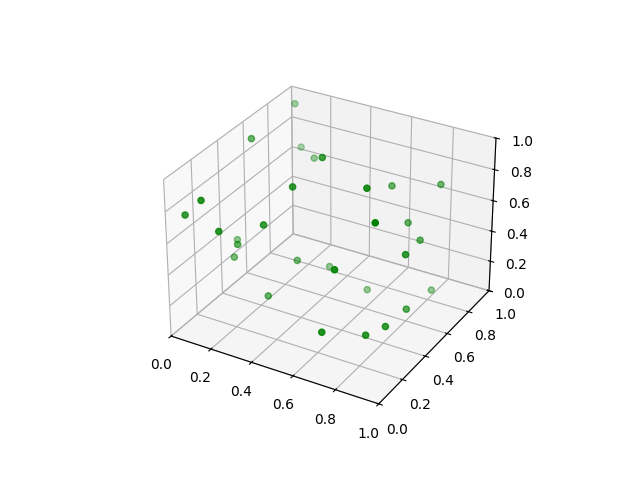

In [17]:
prior = sample("uniform")
print(prior)
show_plot(prior, show_zeolite=False, show_voronoi=False)

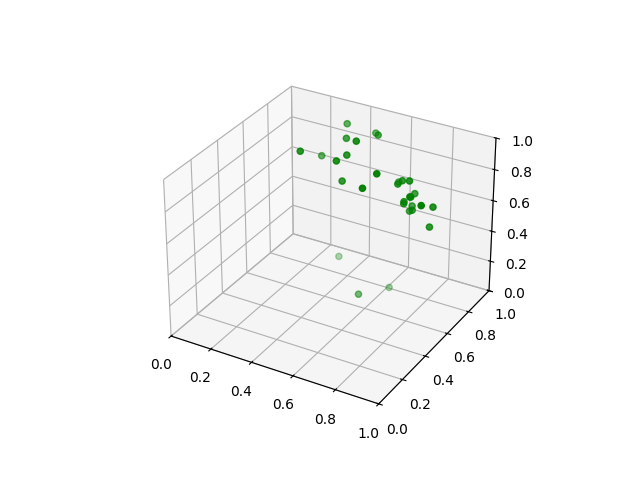

In [18]:
prior = sample("uniform_then_gaussian")
show_plot(prior, show_zeolite=False, show_voronoi=False)

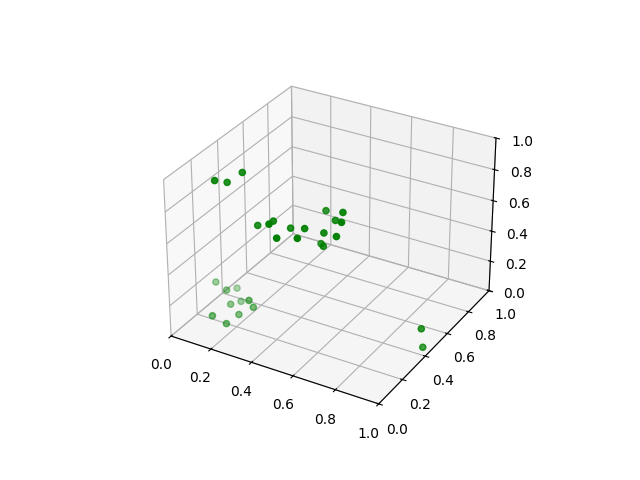

In [21]:
prior = sample("uniform_then_conformer")
show_plot(prior, show_zeolite=False, show_voronoi=False)

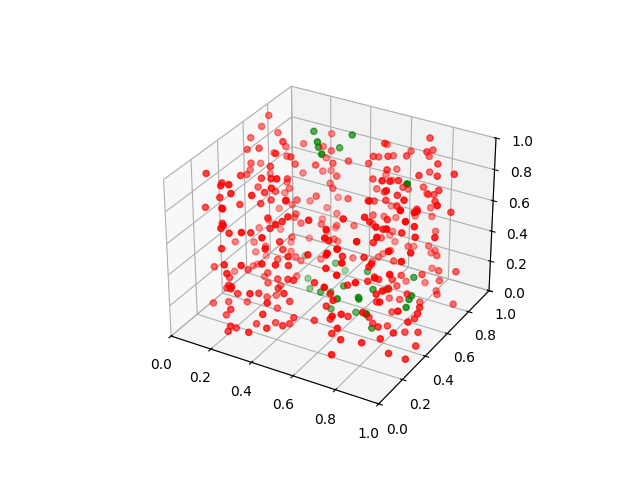

In [24]:
prior = sample("voronoi_then_gaussian")
show_plot(prior, show_zeolite=True, show_voronoi=False)

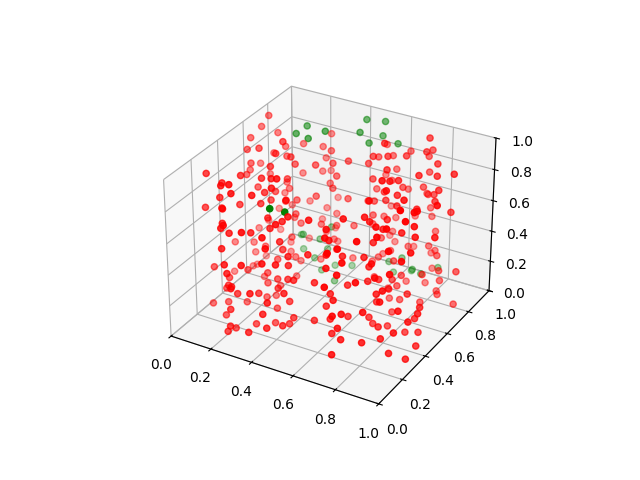

In [28]:
prior = sample("voronoi_then_conformer")
show_plot(prior, show_zeolite=True, show_voronoi=False)